C:\Users\shale\AppData\Local\Temp\ipykernel_32192\921107556.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_data = torch.load('latent_dataset.pt')


Epoch 1/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/40, Loss: 6.1456


Epoch 2/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/40, Loss: 5.9537


Epoch 3/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/40, Loss: 5.7570


Epoch 4/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/40, Loss: 5.5511


Epoch 5/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/40, Loss: 5.3881


Epoch 6/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/40, Loss: 5.1823


Epoch 7/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/40, Loss: 5.0438


Epoch 8/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/40, Loss: 4.8849


Epoch 9/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/40, Loss: 4.7574


Epoch 10/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/40, Loss: 4.6122


Epoch 11/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/40, Loss: 4.4994


Epoch 12/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/40, Loss: 4.3679


Epoch 13/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/40, Loss: 4.2446


Epoch 14/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/40, Loss: 4.2076


Epoch 15/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/40, Loss: 4.0621


Epoch 16/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/40, Loss: 3.9716


Epoch 17/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/40, Loss: 3.9096


Epoch 18/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/40, Loss: 3.8538


Epoch 19/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/40, Loss: 3.7707


Epoch 20/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/40, Loss: 3.7390


Epoch 21/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/40, Loss: 3.6821


Epoch 22/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/40, Loss: 3.6509


Epoch 23/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/40, Loss: 3.6702


Epoch 24/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/40, Loss: 3.6761


Epoch 25/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/40, Loss: 3.6779


Epoch 26/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/40, Loss: 3.6841


Epoch 27/40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/40, Loss: 3.7103
Early stopping triggered.
Sample saved to generated_sample.wav


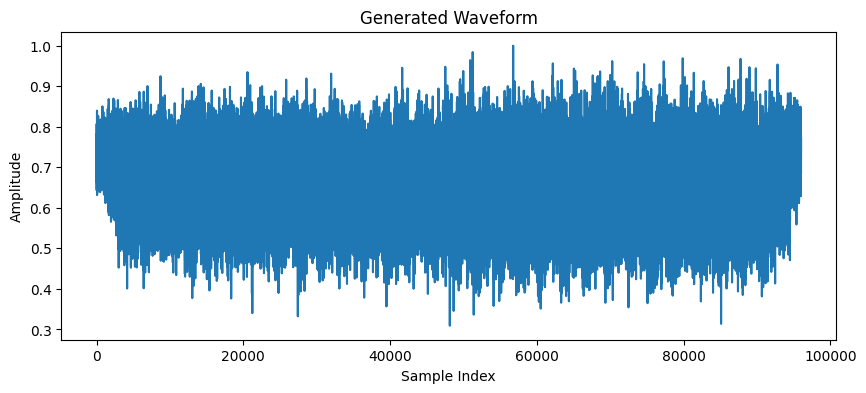

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.auto import tqdm
import torchaudio
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, embedding_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(embedding_dim, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.n_embeddings = n_embeddings
        self.embeddings = nn.Embedding(n_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / n_embeddings, 1 / n_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized = torch.index_select(self.embeddings.weight, 0, encoding_indices.view(-1)).view(inputs.shape)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        quantized = inputs + (quantized - inputs).detach()
        return quantized, loss, encoding_indices

class VQVAE2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, n_embeddings=512, embedding_dim=64):
        super(VQVAE2, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, embedding_dim)
        self.vq = VectorQuantizer(n_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_channels, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, _ = self.vq(z)
        x_recon = self.decoder(quantized)
        x_recon = F.interpolate(x_recon, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return x_recon, vq_loss

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.size = int(3.4 * 24000)
        self.scaling = scaling
        self.data = self.create_data(hdf)
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std = self.data.std()
            self.data = (self.data - self.mean) / self.std
        elif scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def create_data(self, hdf):
        keys = list(hdf.keys())
        data = []
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')
            data.append(sample)
        return torch.tensor(data, dtype=torch.float32)

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        elif self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

def train_vqvae2(model, dataloader, epochs=40, lr=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    best_loss = float('inf')
    patience_counter = 0
    patience_limit = 5

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for latents in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
            optimizer.zero_grad()
            outputs, vq_loss = model(latents)
            loss = criterion(outputs, latents) + vq_loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')
        scheduler.step(avg_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break

class LatentDataset(Dataset):
    def __init__(self, latents_tensor):
        self.latents_tensor = latents_tensor

    def __len__(self):
        return len(self.latents_tensor)

    def __getitem__(self, idx):
        return self.latents_tensor[idx]

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

def generate_samples(model, num_samples=1, save_path='generated_sample.wav', sampling_rate=24000, output_length=24000):
    model.eval()
    with torch.no_grad():
        dummy_input = torch.randn(1, 1, 64, 265000).to(next(model.parameters()).device)
        z = model.encoder(dummy_input)
        _, _, latent_height, latent_width = z.shape
        encoding_indices = torch.randint(0, model.vq.n_embeddings, (num_samples, latent_height, latent_width)).to(next(model.parameters()).device)
        quantized_latents = model.vq.embeddings(encoding_indices).view(num_samples, model.vq.embedding_dim, latent_height, latent_width)
        noise = 0.1 * torch.randn_like(quantized_latents)
        quantized_latents += noise
        generated_samples = model.decoder(quantized_latents)
        generated_waveform = generated_samples.view(num_samples, -1)
        generated_waveform = F.interpolate(generated_waveform.unsqueeze(1), size=(output_length,), mode='linear', align_corners=False).squeeze().cpu()
        generated_waveform = generated_waveform / torch.max(torch.abs(generated_waveform))
        torchaudio.save(save_path, generated_waveform.unsqueeze(0), sampling_rate)
        print(f"Sample saved to {save_path}")
        plt.figure(figsize=(10, 4))
        plt.plot(generated_waveform.numpy())
        plt.title('Generated Waveform')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

latent_data = torch.load('latent_dataset.pt')
latent_dataset = LatentDataset(latent_data)
train_loader = DataLoader(latent_dataset, batch_size=16, shuffle=True)
vqvae2_model = VQVAE2()
initialize_weights(vqvae2_model)
train_vqvae2(vqvae2_model, train_loader)
generate_samples(vqvae2_model, num_samples=1, output_length=96000)
